# Cryptocurrency Price Trend Detection Recurrent Neural Network Model
This notebook will walkthrough the steps to build a model to predict cryptocurrency price trend

**This code is not intended to be financial advice.**

**USE AT YOUR OWN RISK**

---

<a id='outline'></a>
## Project Outline
1. [Importing Packages](#section1)
2. [Load Data](#section2)
3. [Add Features and Labels](#section3)
4. [Preprocessing for Model](#section4)
5. [Model - Long Short Term Memory (LSTM)](#section5)
6. [Evaluation](#section6)
7. [Predictions](#section7)
8. [Save model and scaler](#section8)

<a id='section1'></a>
### 1. Importing Packages

In [1]:
import load_data as ld
import indicators as ind
import scoring as sc

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from keras import regularizers

from tqdm.notebook import tqdm_notebook
from tqdm.keras import TqdmCallback

import joblib

[top](#outline)

<a id='section2'></a>
### 2. Load Data

In [2]:
# Load data from SQL database

coin = 'ETHUSD'
timestamp = '2018-01-01 00:00:00+00:00'
timeframe = '1h'

bars = ld.load_df_from_date(coin, timeframe, timestamp, messages=False)

[top](#outline)

<a id='section3'></a>
### 3. Add Features and Labels

In [3]:
# Add features

bars = ind.add_features(bars)

In [4]:
# Remove excess columns and drop NaNs

bars = bars.dropna()

to_delete = ['id', 'coin_id',
             'high', 'low', 'open',
             'close', 'volume'
             ]

data = bars.drop(to_delete, axis=1)
data = data.dropna()

In [5]:
# Add labels

data ['target'] = ind.targetTrend(bars.close)

[top](#outline)

<a id='section4'></a>
### 4. Preprocessing for Model

In [6]:
def preprocessing(
    input_df, 
    N=5, 
    train_size=0.8, 
    test_size=0.2):
    '''
    Returns numpy arrays for model training and validation, and sklearn scaler object
    
    input_df - DataFrame containing features and labels, label column must be named 'target'
    N - int of length of sequence lookback
    train_size - float of fraction of data to split into training data
    test_size - float of fraction of data to split into testing data
    '''
    
    df = input_df.copy()
       
    # Split data into features and labels
    X = df.drop('target', axis=1)
    y = df.target
    
    # Split into train, val, and test
    n = len(input_df)
    
    X_train = X.iloc[:int(n*train_size)]
    X_test = X.iloc[int(n*(1-test_size)):]
    
    y_train = y.iloc[:int(n*train_size)-N]
    y_test = y.iloc[int(n*(1-test_size)):-N]
          
    # Turn dataframes to numpy arrays
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    
    # Make sequences
    X_train_sequences = []
    X_test_sequences = []
    
    for i in range(N, len(X_train)):
        
        to_append = X_train[i-N:i]       
        X_train_sequences.append(to_append)
        
    for i in range(N, len(X_test)):
        
        to_append = X_test[i-N:i]
        X_test_sequences.append(to_append)
                

    # Convert to numpy arrays
    X_train = np.asarray(X_train_sequences).astype('float32') 
    X_test = np.asarray(X_test_sequences).astype('float32')
    y_train = np.asarray(y_train).astype('float32') 
    y_test = np.asarray(y_test).astype('float32')
    
    # Normalize input
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    
    return X_train, X_test, y_train, y_test, scaler

In [7]:
# Preprocess data

X_train, X_test, y_train, y_test, scaler = preprocessing(data)

[top](#outline)

<a id='section5'></a>
### 5. Model - Long Short Term Memory (LSTM)

In [8]:
# 3 category labels

model = tf.keras.models.Sequential([
    layers.LSTM(16,
             return_sequences=True,
               ),
    layers.Dropout(0.4),
    layers.LayerNormalization(),

    layers.Flatten(),

    layers.Dense(3, activation='softmax'),
])

In [9]:
def compile_and_fit(
    model, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    shuffle=False,
    patience=3, 
    MAX_EPOCHS=20, 
    monitor='val_loss',
    checkpoint_monitor='val_accuracy',
    learning_rate=1e-4, 
    decay=1e-6, 
    verbose=2, 
    checkpoint_verbose=1):
    
    '''
    Compiles and trains model
    
    model - keras model object
    X_train - numpy array of training features
    y_train - numpy array of training labels
    X_test - numpy array of testing features
    y_test - numpy array of training features
    
    refer to keras documentation for other options
    '''
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                    patience=patience,
                                                    min_delta=0.0001)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', 
                                                    monitor=checkpoint_monitor, 
                                                    mode='max', 
                                                    verbose=checkpoint_verbose, 
                                                    save_best_only=True)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay),
        metrics=['accuracy'])
    
        
    history = model.fit(
        X_train, 
        y_train,
        epochs=MAX_EPOCHS,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, checkpoint, TqdmCallback(verbose=verbose)],
        shuffle=shuffle,
        verbose=0)

    return history

In [10]:
history = compile_and_fit(
    model, 
    X_train, 
    y_train, 
    X_test,
    y_test)

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 1: val_accuracy improved from -inf to 0.58208, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 2: val_accuracy improved from 0.58208 to 0.60436, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 3: val_accuracy improved from 0.60436 to 0.62639, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 4: val_accuracy improved from 0.62639 to 0.64419, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 5: val_accuracy improved from 0.64419 to 0.65666, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 6: val_accuracy improved from 0.65666 to 0.66610, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 7: val_accuracy improved from 0.66610 to 0.67615, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 8: val_accuracy improved from 0.67615 to 0.68523, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 9: val_accuracy improved from 0.68523 to 0.69128, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 10: val_accuracy improved from 0.69128 to 0.69697, saving model to best_model.h5


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 11: val_accuracy did not improve from 0.69697


  0%|          | 0.00/1.03k [00:00<?, ?batch/s]


Epoch 12: val_accuracy improved from 0.69697 to 0.70000, saving model to best_model.h5


In [11]:
# Load best model

model = keras.models.load_model('best_model.h5')

[top](#outline)

<a id='section6'></a>
### 6. Evaluation

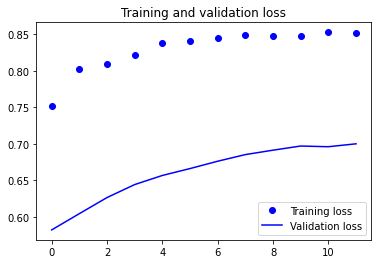

In [12]:
# Training vs Validation loss

loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
def perturbation_rank(
    model,
    x,
    y,
    names):
    
    '''
    Describes amount of error generated by randomly shuffling a single feature
    The features with greater error describe the features with highest importance
    
    model - keras trained model
    x - numpy array of features
    y - numpy array of labels
    names - list of feature column names
    
    source: https://medium.com/coinmonks/crypto-feature-importance-for-deep-reinforcement-learning-38416616c2a36-8416616c2a36
    '''
    
    errors = []

    X_saved = np.copy(x)
    
    for i in tqdm_notebook(range(x.shape[2])):

        # Convert to numpy, shuffle, convert back to tensor, predict
        np.random.shuffle(x[:,:,i])
        pred = model.predict(x, verbose=0)

        # log_loss requires (classification target, probabilities)
        error = metrics.log_loss(y, pred)
        errors.append(error)

        # Reset x to saved tensor matrix
        x = X_saved
    
    max_error = np.max(errors)
    importance = [e/max_error for e in errors]
    
    data = {'name':names,'error':errors,'importance':importance}
    result = pd.DataFrame(data,columns = ['name','error','importance'])
    result.sort_values(by=['importance'],ascending=[0],inplace=True)
    result.reset_index(inplace=True,drop=True)
    return result

In [14]:
# Generate perturbation ranks

names = list(data.columns)
names.remove('target')
    
rank = perturbation_rank(
    model, 
    X_test,
    y_test,  
    names)

display(rank)

  0%|          | 0/38 [00:00<?, ?it/s]

,name,error,importance
0,percent_diff_3,2.093944,1.000000
1,supertrend_direction,2.093938,0.999997
2,percent_diff_1,2.089561,0.997907
3,percent_diff_2,2.087396,0.996873
4,percent_diff_4,2.083293,0.994913
5,supertrend_ratio,2.079099,0.992910
6,price_cross_ZLMA55,2.076110,0.991483
7,percent_diff_5,2.059105,0.983362
8,percent_diff_6,2.043818,0.976062
9,percent_diff_7,2.042646,0.975502


[top](#outline)

<a id='section7'></a>
### 7. Predictions

In [15]:
def predictions_df(model, X_test, input_df, N=0):
    '''
    Returns DataFrame of predictions and actions from keras model
    
    model - trained keras model
    X_test - numpy array of features
    input_df - DataFrame with timeseries index and candlestick data
    N - int of length of sequence lookback
    '''
    predictions = model.predict(X_test)

    final_predictions = []
    for i, value in enumerate(predictions):
        final_predictions.append(np.argmax(predictions[i]))
    if N > 1:
        predictions = pd.Series(final_predictions, index=input_df.index[-(len(final_predictions))-(N-1):-(N-1)])
    else:
        predictions = pd.Series(final_predictions, index=input_df.index[-(len(final_predictions)):])
    #predictions = pd.Series(final_predictions, index=input_df.index[-(len(final_predictions)):])
    df = input_df[-len(predictions):].copy()
    df.loc[:,'target'] = predictions.copy()
    df.loc[:,'action'] = (df.target.shift(1) != df.target)
    
    return df

In [16]:
# Generate dataframe of predictions and actions

df = predictions_df(model, X_test, bars, N=5)

259/259 [==============================] - 1s 3ms/step


In [17]:
def plot(
    df, 
    start, 
    stop, 
    close='close', 
    sell_target=0, 
    hold_target=1, 
    buy_target=2,
    hold_size=5):
    
    '''
    Plots visualization of predicted labels
    
    df - DataFrame containing predicted labels
    start - int of start index
    stop - int of stop index
    close - str of price column to plot
    sell_target - int of downtrend label
    hold_target - int of no trend label
    buy_target - int of uptrend label
    hold_size - int of size for no trend label
    '''

        
    plot_df = pd.DataFrame(
        {'close': df[close][start:stop],
         'target': df.target[start:stop], 
        },
         index=df.index[start:stop])
        
    # Dict to assign color
    cdict = {sell_target: 'red', hold_target: 'black', buy_target: 'green'}

    # Initialize plot
    plt.rcParams['figure.figsize'] = [15, 7]
    fig, ax = plt.subplots()

    # Plot the closing price as a line
    ax.plot(plot_df.index, plot_df.close, c='black', zorder=-1)

    # Color code where you would be buying vs selling
    for g in np.unique(plot_df.target):
        
        if np.isnan(g):
            continue
            
        elif g == hold_target:
            ax.scatter(
                plot_df.index[plot_df.target == g],
                plot_df.close[plot_df.target == g],
                c=cdict[g], label=g, s=hold_size, zorder=1)
        else:
            ax.scatter(
                plot_df.index[plot_df.target == g],
                plot_df.close[plot_df.target == g],
                c=cdict[g], label=g, s=15, zorder=1)
            
    ax.legend()

    ax.grid()

    plt.show()

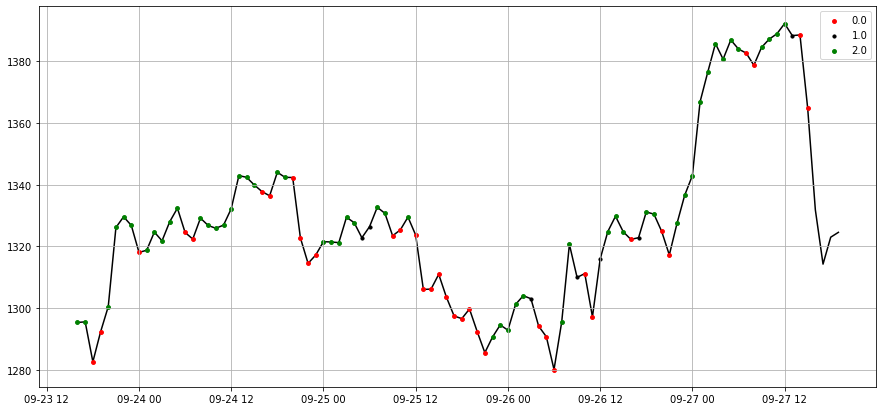

In [18]:
start = -100
stop = None

plot(
    df, 
    start, 
    stop, 
    hold_size=10)

In [19]:
# Find best trading parameters

#start = df.index[0]
start = datetime.fromisoformat('2022-09-01 00:00:00+00:00')
N=5
minutes=60

for leverage in [1, 5, 10]:
    fee = leverage * 0.002
    best = sc.bestRisk(
        df=df, 
        start=start, 
        fee=fee, 
        leverage=leverage, 
        N=minutes*(N-1),
        buy_target=2,
        sell_target=0,
        hold_target=1)
    print(best)

  0%|          | 0/10 [00:00<?, ?it/s]

{'balance': 9868.29, 'moves': 191, 'win_percent': 39.79, 'sl_count': 0, 'tp_count': 1, 'signal_exit_count': 190, 'sl': 1.0, 'tp': 0.1, 'trade_risk': 0.1, 'start': datetime.datetime(2022, 9, 1, 0, 0, tzinfo=datetime.timezone.utc)}


  0%|          | 0/10 [00:00<?, ?it/s]

{'balance': 64357.58, 'moves': 191, 'win_percent': 50.26, 'sl_count': 0, 'tp_count': 44, 'signal_exit_count': 147, 'sl': 1.0, 'tp': 0.1, 'trade_risk': 1.0, 'start': datetime.datetime(2022, 9, 1, 0, 0, tzinfo=datetime.timezone.utc)}


  0%|          | 0/10 [00:00<?, ?it/s]

{'balance': 793284.56, 'moves': 191, 'win_percent': 68.59, 'sl_count': 0, 'tp_count': 104, 'signal_exit_count': 87, 'sl': 1.0, 'tp': 0.1, 'trade_risk': 1.0, 'start': datetime.datetime(2022, 9, 1, 0, 0, tzinfo=datetime.timezone.utc)}


[top](#outline)

<a id='section8'></a>
### 8. Save model and scaler

In [20]:
path = 'model.h5'
model.save(path)

In [21]:
scaler_path = 'scaler.h5'
joblib.dump(scaler, scaler_path)

['scaler.h5']

[top](#outline)